In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from exfor_tools import (
    get_exfor_differential_data,
    sort_measurements_by_energy,
    ExforEntryAngularDistribution,
    AngularDistribution,
    init_exfor_db,
)

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


## Demonstration of data retrieval and plotting for various reactions and quantities

In [3]:
ca48_pp = ExforEntryAngularDistribution(
    entry="C1216",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dA",
)
ca48_dd = ExforEntryAngularDistribution(
    entry="C1216",
    target=(48, 20),
    projectile=(2, 1),
    quantity="dXS/dA",
)
ca48_nn = ExforEntryAngularDistribution(
    entry="13508",
    target=(48, 20),
    projectile=(1, 0),
    quantity="dXS/dA",
)

TypeError: float() argument must be a string or a real number, not 'NoneType'

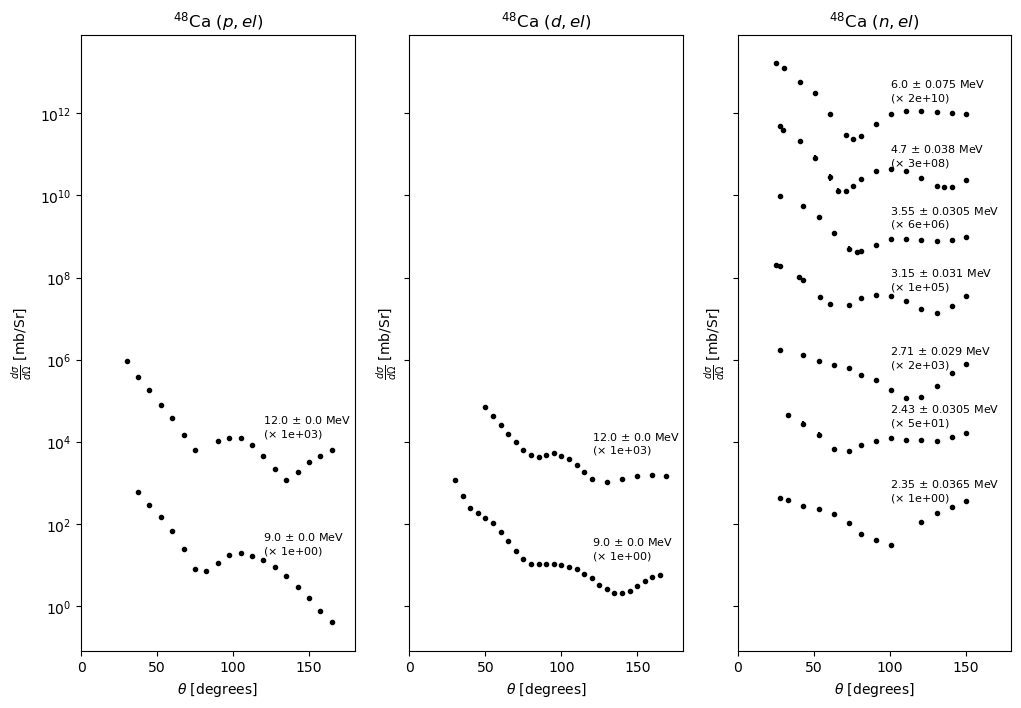

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
ca48_pp.plot_experiment(ax1, offsets=1000, label_hloc_deg=120, label_offset_factor=4)
ca48_dd.plot_experiment(ax2, offsets=1000, label_hloc_deg=120, label_offset_factor=4)
ca48_nn.plot_experiment(ax3, offsets=50, label_hloc_deg=100, label_offset_factor=2)

In [7]:
ca48_pp_ana = ExforDifferentialData(
    entry="O0239",
    target=(48, 20),
    projectile=(1, 1),
    quantity="Ay",
    products=["EL"],
)

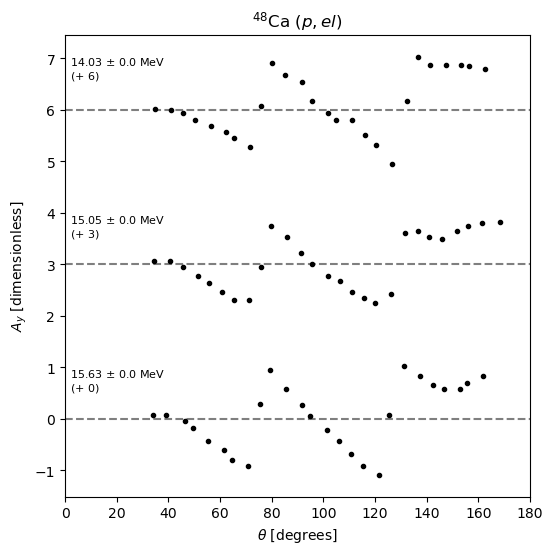

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ca48_pp_ana.plot_experiment(
    ax,
    offsets=3,
    log=False,
    label_offset_factor=0.5,
    label_hloc_deg=2,
    add_baseline=True,
)

In [9]:
ca48_pp_rth = ExforDifferentialData(
    entry="O0239",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dRuth",
    products=["EL"],
)

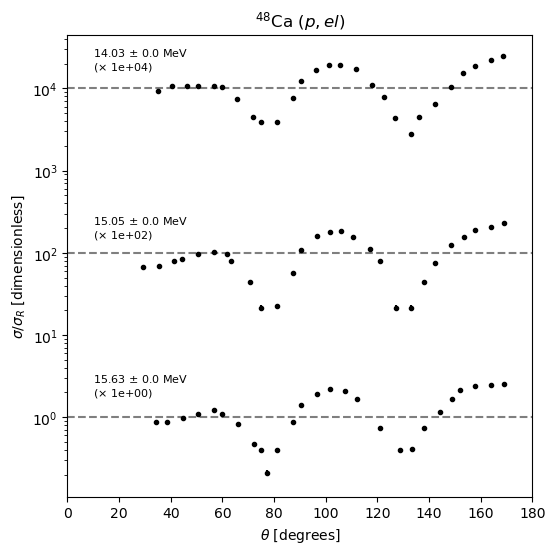

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ca48_pp_rth.plot_experiment(
    ax, offsets=100, label_hloc_deg=10, label_offset_factor=1.5, add_baseline=True
)

## Querying for multiple entries
Let's figure out how to query EXFOR for multiple entries and plot them all

In [11]:
all_entries_lead208_pp = get_exfor_differential_data(
    target=(208, 82),
    projectile=(1, 1),
    quantity="dXS/dA",
    product="EL",
    energy_range=[10, 60],  # MeV
)
print(f"Found {len(all_entries_lead208_pp.keys())} entries")
print(all_entries_lead208_pp.keys())

There was an error reading entry C1292, it will be skipped:
Missing 'Angle' field!
There was an error reading entry O0187, it will be skipped:
Missing 'Angle' field!
There was an error reading entry O0191, it will be skipped:
Missing 'Angle' field!
Found 14 entries
dict_keys(['C0893', 'C1019', 'C2700', 'E1846', 'O0142', 'O0157', 'O0166', 'O0187', 'O0191', 'O0208', 'O0225', 'O0287', 'O0391', 'O0598'])


Now, let's plot measurements from all of those entries on the same figure

In [12]:
measurements_condensed = sort_measurements_by_energy(all_entries_lead208_pp)

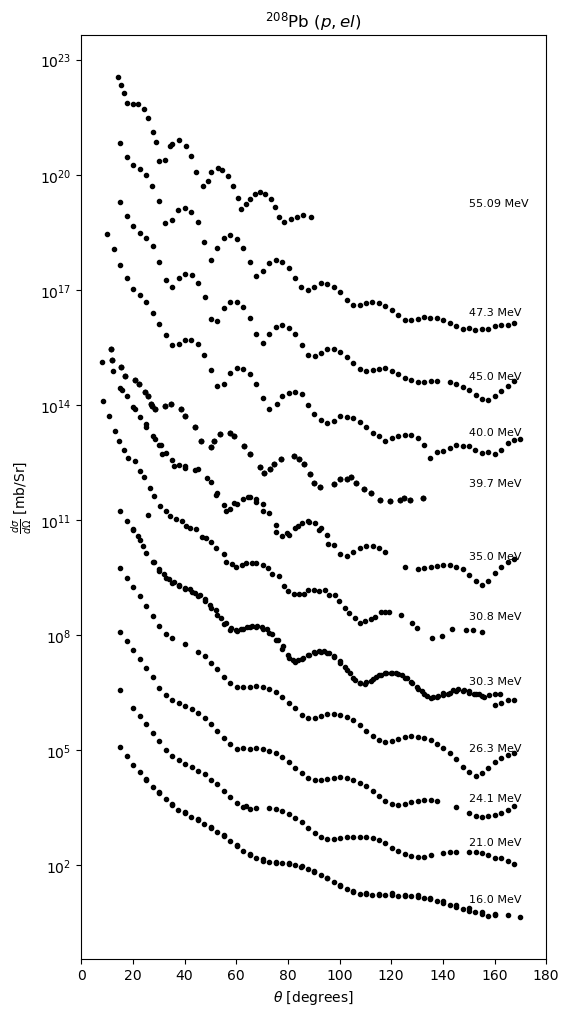

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
entry = all_entries_lead208_pp["C0893"]
entry.plot_experiment(
    ax,
    offsets=50,
    measurements=measurements_condensed,
    label_offset_factor=2,
    label_hloc_deg=150,
    label_energy_err=False,
    label_offset=False,
)
plt.savefig("lead_208_pp_dxds.png")

### Now, let's plot each entry individually

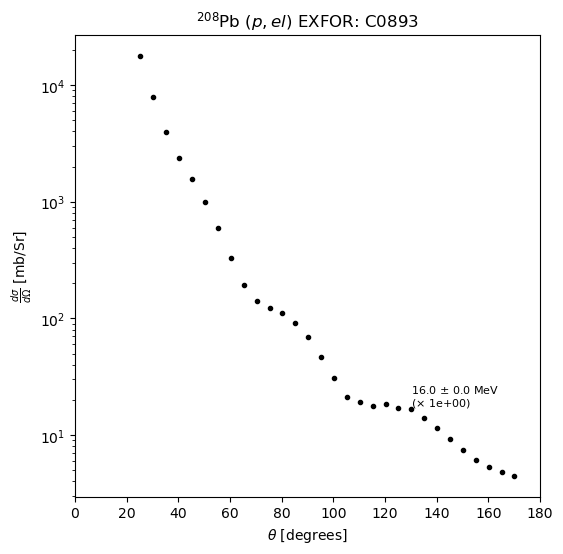

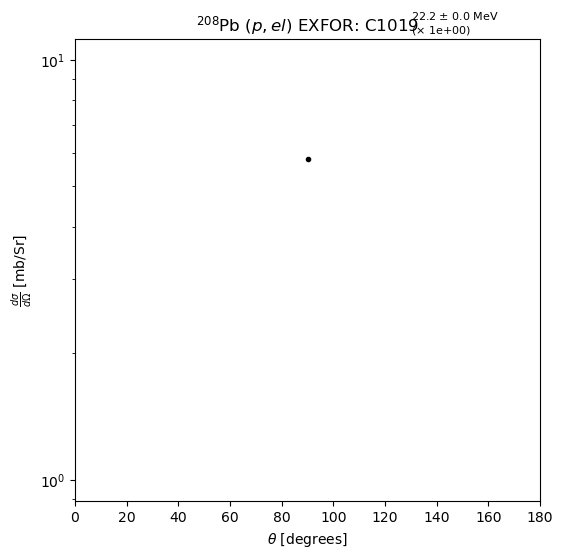

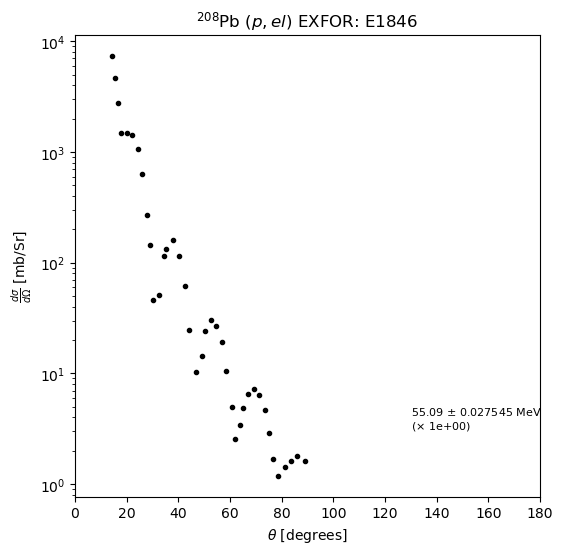

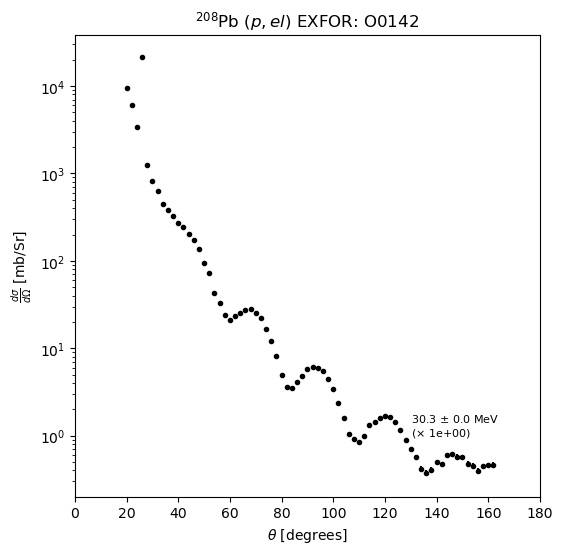

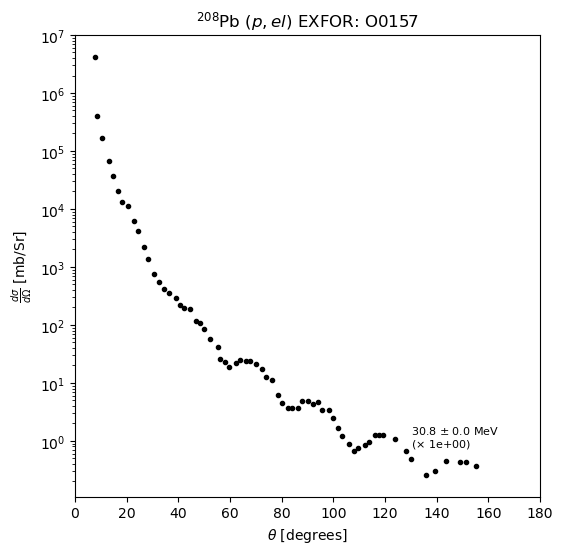

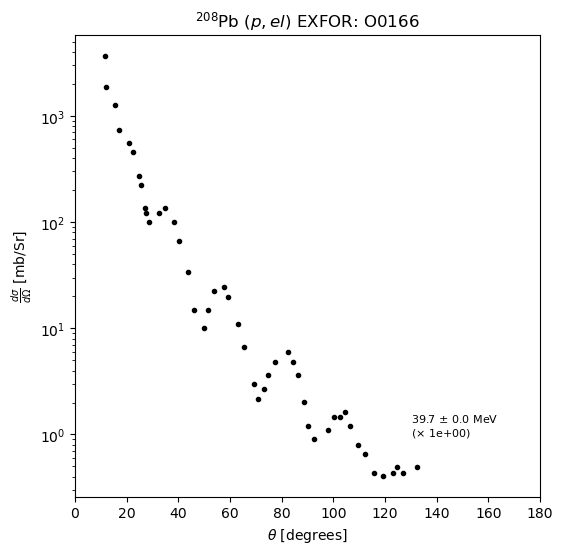

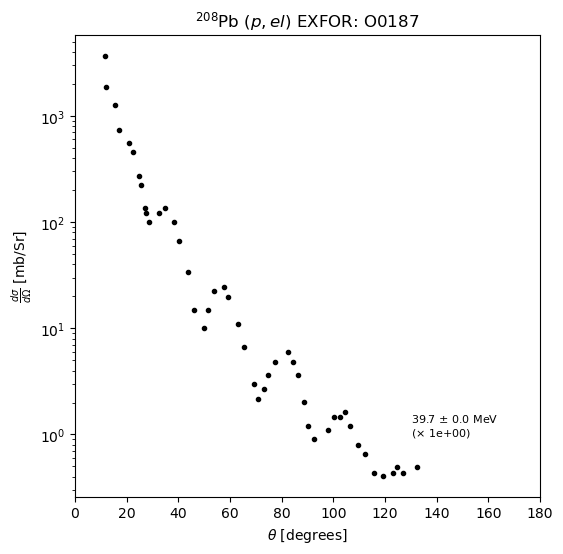

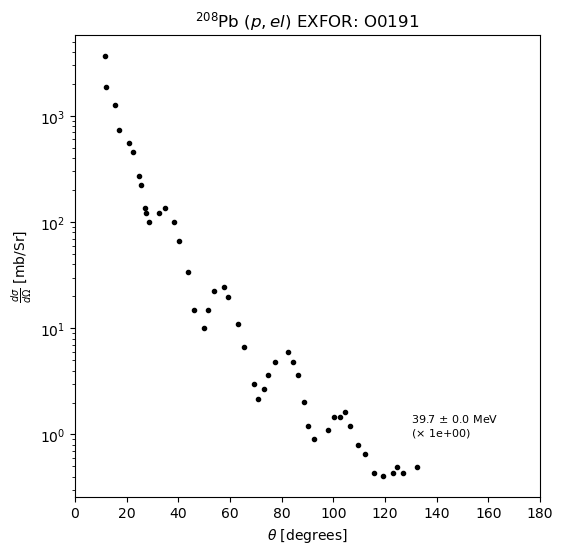

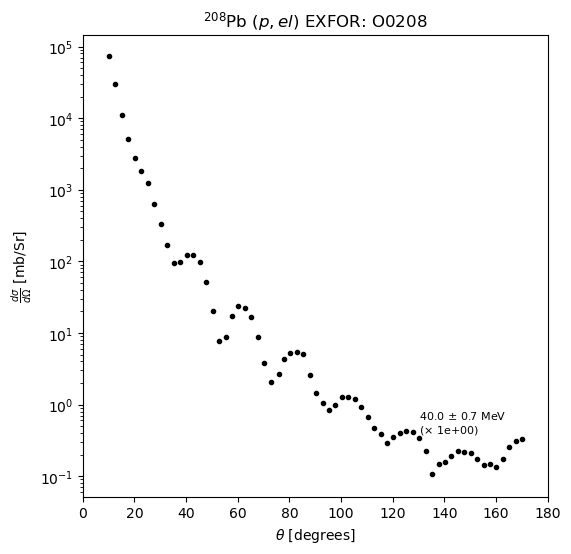

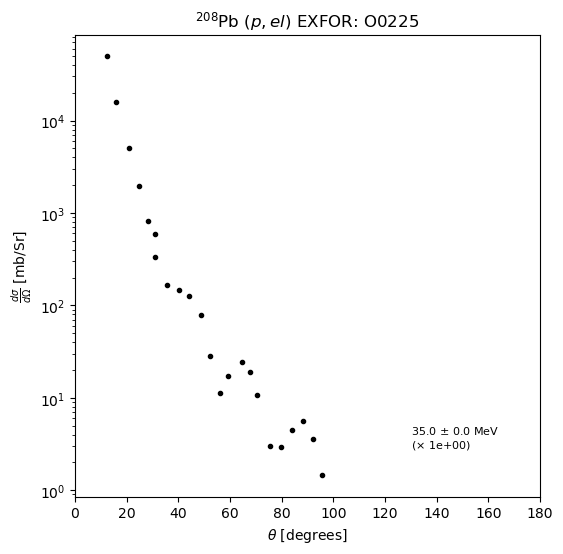

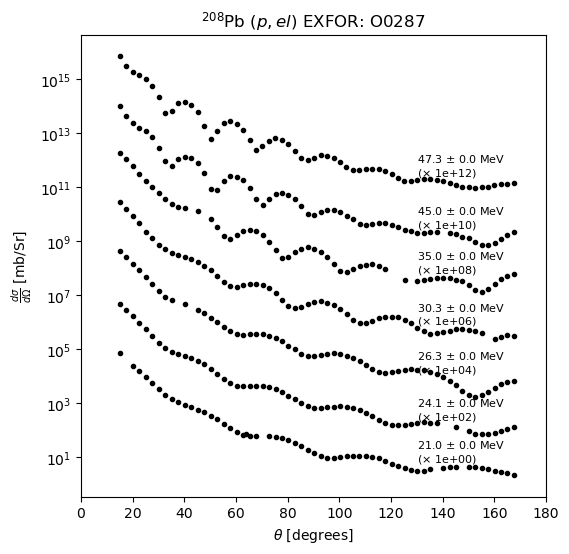

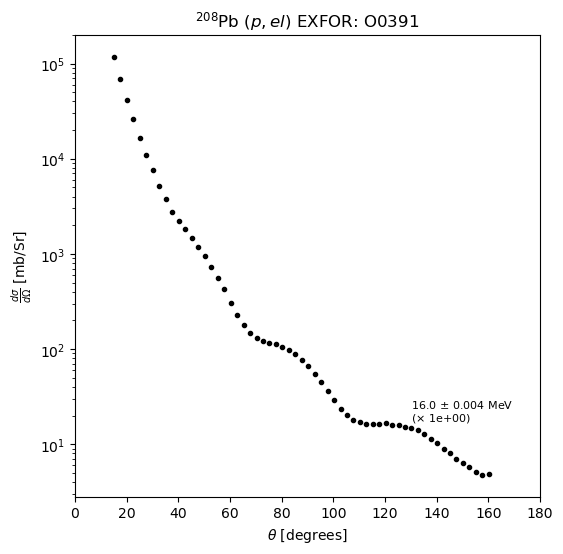

In [14]:
constant_offset = 100
for entry, data in all_entries_lead208_pp.items():
    if len(data.measurements) < 10:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        data.plot_experiment(ax, offsets=constant_offset)
        ax.set_title(f"{ax.get_title()} EXFOR: {entry}")
        plt.show()

In [15]:
all_entries_lead208_pp = get_exfor_differential_data(
    target=(206, 82),
    projectile=(1, 0),
    quantity="dXS/dA",
    product="EL",
    energy_range=[0, 200],  # MeV
)

In [16]:
sorted_ms = sort_measurements_by_energy(all_entries_lead208_pp)
print(len(sorted_ms))

44
